<a href="https://colab.research.google.com/github/09334677600f/Code-for-Chapter-4/blob/main/Gradient_Boosting_Regression(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# کتابخانه‌ها

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
import optuna
import gc

C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
df = pd.read_excel("final_file1 (2).xlsx")

In [ ]:

# آماده‌سازی داده‌ها

columns_to_drop = [
    "ID", "Accident_ID", "تعداد تصادف",
    "تاریخ", "زمان تماس", "ساعت رسیدن به محل حادثه"
]
df = df.drop(columns=[c for c in columns_to_drop if c in df.columns])
df = df.dropna()
print(f"تعداد رکورد بعد از حذف NaN: {df.shape[0]}")  # 22099

X_cols = [
    "سن بیمار", "جنسیت", "زمان شب و روز",
    "نوع روز", "فصل", "ساعت اوج ترافیک"
]
X = df[X_cols].copy()
y = df["مدت زمان"].copy()  # فقط رگرسیون روی مدت زمان

# پیش‌پردازش
categorical_cols = ["جنسیت", "زمان شب و روز", "نوع روز", "فصل", "ساعت اوج ترافیک"]
numeric_cols = ["سن بیمار"]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ],
    remainder='drop'
)
X_processed = preprocessor.fit_transform(X)

feature_names = numeric_cols + preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols).tolist()

#  train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42
)
print(f"Train: {X_train.shape[0]} رکورد، Test: {X_test.shape[0]} رکورد")

تعداد رکورد بعد از حذف NaN: 22103
Train: 17682 رکورد، Test: 4421 رکورد


In [ ]:

# تابع هدف Optuna برای Gradient Boosting Regression
def objective(trial):

    n_estimators = trial.suggest_int("n_estimators", 50, 200)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
    max_depth = trial.suggest_int("max_depth", 1, 5)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = GradientBoostingRegressor(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            random_state=42
        )

        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        mae = mean_absolute_error(y_val, y_pred)
        scores.append(mae)

        # مدیریت حافظه
        del model
        gc.collect()

    return np.mean(scores)  # هدف: کمینه کردن MAE

In [ ]:

# اجرای Optuna

print("شروع بهینه‌سازی Optuna برای Gradient Boosting Regression ...")

study = optuna.create_study(
    direction='minimize',  # چون MAE را کمینه می‌کنیم
    sampler=optuna.samplers.TPESampler(seed=42)
)
study.optimize(objective, n_trials=30, show_progress_bar=True)

best_params = study.best_params
print("\nبهینه‌سازی تمام شد!")
print("بهترین hyperparameters:")
print(best_params)


[I 2026-01-08 03:14:34,524] A new study created in memory with name: no-name-26b7a1b8-ea75-490e-9eae-9ce6f8b3bf72


شروع بهینه‌سازی Optuna برای Gradient Boosting Regression ...


Best trial: 0. Best value: 4.48811:   3%|█▌                                             | 1/30 [00:11<05:27, 11.28s/it]

[I 2026-01-08 03:14:45,809] Trial 0 finished with value: 4.488112263817422 and parameters: {'n_estimators': 106, 'learning_rate': 0.2536999076681772, 'max_depth': 4}. Best is trial 0 with value: 4.488112263817422.


Best trial: 1. Best value: 4.43566:   7%|███▏                                           | 2/30 [00:16<03:37,  7.76s/it]

[I 2026-01-08 03:14:51,098] Trial 1 finished with value: 4.435662216025793 and parameters: {'n_estimators': 140, 'learning_rate': 0.01700037298921102, 'max_depth': 1}. Best is trial 1 with value: 4.435662216025793.


Best trial: 1. Best value: 4.43566:  10%|████▋                                          | 3/30 [00:22<03:11,  7.11s/it]

[I 2026-01-08 03:14:57,427] Trial 2 finished with value: 4.451201165668376 and parameters: {'n_estimators': 58, 'learning_rate': 0.19030368381735815, 'max_depth': 4}. Best is trial 1 with value: 4.435662216025793.


Best trial: 3. Best value: 4.4314:  13%|██████▍                                         | 4/30 [00:42<05:15, 12.13s/it]

[I 2026-01-08 03:15:17,247] Trial 3 finished with value: 4.431395486924742 and parameters: {'n_estimators': 156, 'learning_rate': 0.010725209743171996, 'max_depth': 5}. Best is trial 3 with value: 4.431395486924742.


Best trial: 3. Best value: 4.4314:  17%|████████                                        | 5/30 [00:49<04:16, 10.24s/it]

[I 2026-01-08 03:15:24,146] Trial 4 finished with value: 4.431469714358036 and parameters: {'n_estimators': 175, 'learning_rate': 0.020589728197687916, 'max_depth': 1}. Best is trial 3 with value: 4.431395486924742.


Best trial: 5. Best value: 4.42553:  20%|█████████▍                                     | 6/30 [00:56<03:39,  9.14s/it]

[I 2026-01-08 03:15:31,135] Trial 5 finished with value: 4.42553108077823 and parameters: {'n_estimators': 77, 'learning_rate': 0.028145092716060652, 'max_depth': 3}. Best is trial 5 with value: 4.42553108077823.


Best trial: 5. Best value: 4.42553:  23%|██████████▉                                    | 7/30 [01:08<03:48,  9.92s/it]

[I 2026-01-08 03:15:42,686] Trial 6 finished with value: 4.428287889759519 and parameters: {'n_estimators': 115, 'learning_rate': 0.02692655251486473, 'max_depth': 4}. Best is trial 5 with value: 4.42553108077823.


Best trial: 5. Best value: 4.42553:  27%|████████████▌                                  | 8/30 [01:12<03:00,  8.22s/it]

[I 2026-01-08 03:15:47,261] Trial 7 finished with value: 4.427429572410206 and parameters: {'n_estimators': 71, 'learning_rate': 0.027010527749605478, 'max_depth': 2}. Best is trial 5 with value: 4.42553108077823.


Best trial: 5. Best value: 4.42553:  30%|██████████████                                 | 9/30 [01:17<02:27,  7.04s/it]

[I 2026-01-08 03:15:51,710] Trial 8 finished with value: 4.430829967076952 and parameters: {'n_estimators': 118, 'learning_rate': 0.14447746112718687, 'max_depth': 1}. Best is trial 5 with value: 4.42553108077823.


Best trial: 5. Best value: 4.42553:  33%|███████████████▎                              | 10/30 [01:21<02:07,  6.35s/it]

[I 2026-01-08 03:15:56,517] Trial 9 finished with value: 4.429534903529389 and parameters: {'n_estimators': 127, 'learning_rate': 0.07500118950416987, 'max_depth': 1}. Best is trial 5 with value: 4.42553108077823.


Best trial: 5. Best value: 4.42553:  37%|████████████████▊                             | 11/30 [01:29<02:04,  6.57s/it]

[I 2026-01-08 03:16:03,596] Trial 10 finished with value: 4.427265306358441 and parameters: {'n_estimators': 81, 'learning_rate': 0.050022091577274753, 'max_depth': 3}. Best is trial 5 with value: 4.42553108077823.


Best trial: 5. Best value: 4.42553:  40%|██████████████████▍                           | 12/30 [01:36<02:04,  6.91s/it]

[I 2026-01-08 03:16:11,271] Trial 11 finished with value: 4.426779790876145 and parameters: {'n_estimators': 84, 'learning_rate': 0.0509156997719088, 'max_depth': 3}. Best is trial 5 with value: 4.42553108077823.


Best trial: 5. Best value: 4.42553:  43%|███████████████████▉                          | 13/30 [01:44<02:01,  7.15s/it]

[I 2026-01-08 03:16:18,972] Trial 12 finished with value: 4.429400214738703 and parameters: {'n_estimators': 88, 'learning_rate': 0.06400126293286251, 'max_depth': 3}. Best is trial 5 with value: 4.42553108077823.


Best trial: 5. Best value: 4.42553:  47%|█████████████████████▍                        | 14/30 [01:48<01:37,  6.08s/it]

[I 2026-01-08 03:16:22,584] Trial 13 finished with value: 4.426814896870444 and parameters: {'n_estimators': 51, 'learning_rate': 0.039507424474759543, 'max_depth': 2}. Best is trial 5 with value: 4.42553108077823.


Best trial: 5. Best value: 4.42553:  50%|███████████████████████                       | 15/30 [01:53<01:28,  5.92s/it]

[I 2026-01-08 03:16:28,142] Trial 14 finished with value: 4.426823499528625 and parameters: {'n_estimators': 95, 'learning_rate': 0.0982997272497659, 'max_depth': 2}. Best is trial 5 with value: 4.42553108077823.


Best trial: 5. Best value: 4.42553:  53%|████████████████████████▌                     | 16/30 [01:59<01:24,  6.00s/it]

[I 2026-01-08 03:16:34,329] Trial 15 finished with value: 4.426264504489373 and parameters: {'n_estimators': 73, 'learning_rate': 0.042746116476006964, 'max_depth': 3}. Best is trial 5 with value: 4.42553108077823.


Best trial: 5. Best value: 4.42553:  57%|██████████████████████████                    | 17/30 [02:08<01:26,  6.68s/it]

[I 2026-01-08 03:16:42,572] Trial 16 finished with value: 4.4313636941074375 and parameters: {'n_estimators': 66, 'learning_rate': 0.037370046395123875, 'max_depth': 5}. Best is trial 5 with value: 4.42553108077823.


Best trial: 5. Best value: 4.42553:  60%|███████████████████████████▌                  | 18/30 [02:28<02:09, 10.76s/it]

[I 2026-01-08 03:17:02,843] Trial 17 finished with value: 4.427705789670774 and parameters: {'n_estimators': 196, 'learning_rate': 0.014268247099958734, 'max_depth': 4}. Best is trial 5 with value: 4.42553108077823.


Best trial: 5. Best value: 4.42553:  63%|█████████████████████████████▏                | 19/30 [02:37<01:52, 10.21s/it]

[I 2026-01-08 03:17:11,773] Trial 18 finished with value: 4.425552130145396 and parameters: {'n_estimators': 101, 'learning_rate': 0.026056746963204293, 'max_depth': 3}. Best is trial 5 with value: 4.42553108077823.


Best trial: 19. Best value: 4.42436:  67%|██████████████████████████████               | 20/30 [02:43<01:30,  9.06s/it]

[I 2026-01-08 03:17:18,138] Trial 19 finished with value: 4.424362797715635 and parameters: {'n_estimators': 101, 'learning_rate': 0.026991008145021582, 'max_depth': 2}. Best is trial 19 with value: 4.424362797715635.


Best trial: 19. Best value: 4.42436:  70%|███████████████████████████████▍             | 21/30 [02:52<01:19,  8.86s/it]

[I 2026-01-08 03:17:26,548] Trial 20 finished with value: 4.433343722276668 and parameters: {'n_estimators': 135, 'learning_rate': 0.010277912911900935, 'max_depth': 2}. Best is trial 19 with value: 4.424362797715635.


Best trial: 19. Best value: 4.42436:  73%|█████████████████████████████████            | 22/30 [03:00<01:09,  8.68s/it]

[I 2026-01-08 03:17:34,789] Trial 21 finished with value: 4.4255557209095135 and parameters: {'n_estimators': 102, 'learning_rate': 0.027318623332187025, 'max_depth': 3}. Best is trial 19 with value: 4.424362797715635.


Best trial: 19. Best value: 4.42436:  77%|██████████████████████████████████▌          | 23/30 [03:06<00:55,  7.93s/it]

[I 2026-01-08 03:17:40,972] Trial 22 finished with value: 4.426185718761837 and parameters: {'n_estimators': 102, 'learning_rate': 0.02062473062556103, 'max_depth': 2}. Best is trial 19 with value: 4.424362797715635.


Best trial: 19. Best value: 4.42436:  80%|████████████████████████████████████         | 24/30 [03:15<00:49,  8.30s/it]

[I 2026-01-08 03:17:50,133] Trial 23 finished with value: 4.426177593939175 and parameters: {'n_estimators': 111, 'learning_rate': 0.03210251993977601, 'max_depth': 3}. Best is trial 19 with value: 4.424362797715635.


Best trial: 19. Best value: 4.42436:  83%|█████████████████████████████████████▌       | 25/30 [03:20<00:36,  7.35s/it]

[I 2026-01-08 03:17:55,273] Trial 24 finished with value: 4.42909220304917 and parameters: {'n_estimators': 85, 'learning_rate': 0.019974835455940875, 'max_depth': 2}. Best is trial 19 with value: 4.424362797715635.


Best trial: 19. Best value: 4.42436:  87%|███████████████████████████████████████      | 26/30 [03:31<00:34,  8.50s/it]

[I 2026-01-08 03:18:06,463] Trial 25 finished with value: 4.425642312359103 and parameters: {'n_estimators': 149, 'learning_rate': 0.014173234418533619, 'max_depth': 3}. Best is trial 19 with value: 4.424362797715635.


Best trial: 19. Best value: 4.42436:  90%|████████████████████████████████████████▌    | 27/30 [03:40<00:25,  8.64s/it]

[I 2026-01-08 03:18:15,423] Trial 26 finished with value: 4.4280749071730545 and parameters: {'n_estimators': 93, 'learning_rate': 0.03181032972778976, 'max_depth': 4}. Best is trial 19 with value: 4.424362797715635.


Best trial: 19. Best value: 4.42436:  93%|██████████████████████████████████████████   | 28/30 [03:48<00:16,  8.29s/it]

[I 2026-01-08 03:18:22,903] Trial 27 finished with value: 4.4297137978394705 and parameters: {'n_estimators': 124, 'learning_rate': 0.09783099765964938, 'max_depth': 2}. Best is trial 19 with value: 4.424362797715635.


Best trial: 19. Best value: 4.42436:  97%|███████████████████████████████████████████▌ | 29/30 [03:53<00:07,  7.44s/it]

[I 2026-01-08 03:18:28,354] Trial 28 finished with value: 4.429248031143443 and parameters: {'n_estimators': 63, 'learning_rate': 0.023685149011016107, 'max_depth': 3}. Best is trial 19 with value: 4.424362797715635.


Best trial: 19. Best value: 4.42436: 100%|█████████████████████████████████████████████| 30/30 [04:04<00:00,  8.14s/it]

[I 2026-01-08 03:18:38,663] Trial 29 finished with value: 4.4318442199186485 and parameters: {'n_estimators': 103, 'learning_rate': 0.014114878521220132, 'max_depth': 4}. Best is trial 19 with value: 4.424362797715635.

بهینه‌سازی تمام شد!
بهترین hyperparameters:
{'n_estimators': 101, 'learning_rate': 0.026991008145021582, 'max_depth': 2}


In [ ]:

# آموزش مدل نهایی با بهترین hyperparams

gbr_final = GradientBoostingRegressor(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    random_state=42
)
gbr_final.fit(X_train, y_train)
print("\nمدل نهایی آموزش داده شد!")


مدل نهایی آموزش داده شد!


In [ ]:

# پیش‌بینی روی داده تست و ارزیابی

y_pred_test = gbr_final.predict(X_test)

mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test) * 100

print(f"\nMAE روی داده تست: {mae_test:.3f}")
print(f"MAPE روی داده تست: {mape_test:.2f}%")


MAE روی داده تست: 4.431
MAPE روی داده تست: 51.84%


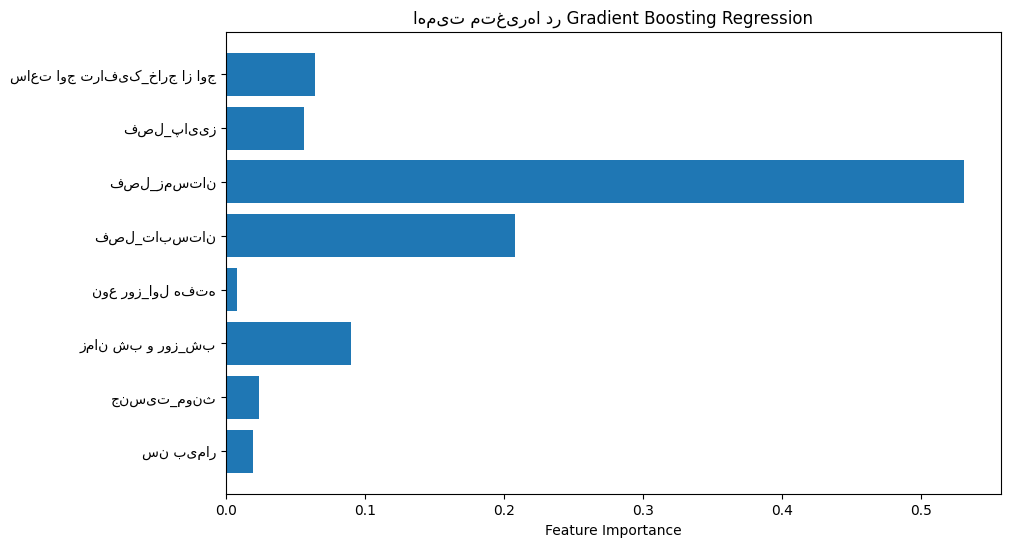

In [ ]:
# اهمیت ویژگی‌ها

importances = gbr_final.feature_importances_

plt.figure(figsize=(10,6))
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.title("اهمیت متغیرها در Gradient Boosting Regression")
plt.show()